<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

try:
    import google.colab  # noqa: F401
except ImportError:
    import pyvista as pv
else:
    !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" && bash "/tmp/vtk-install.sh"
    import pyvista as pv

# Seems that only static plotting is supported by colab at the moment
pv.global_theme.jupyter_backend = "static"
pv.global_theme.notebook = True
pv.start_xvfb()
#pv.set_jupyter_backend('trame')

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,617 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,309 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates

Given a numerical approximation of a random field or random function $Y(\boldsymbol{x})$ over an arbitrary domain $\boldsymbol{x} \in \Omega$ (which can be thought of as a multidimensional space $\mathbb{R}^n$), we want to calculate its corresponding cumulative density function (CDF) $F(y)$ and probability density function (PDF) $f(y)$ such that these functions are continuous and make the best possible use of the available data. The CDF of $Y(\boldsymbol{x})$ is given by
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\boldsymbol{x}) d \boldsymbol{x},
\end{equation*}
its PDF by $f(y) = \partial_y F(y)$ and the indicator function is given by
\begin{equation*}
    \mathbb{I}(y,\boldsymbol{x}) =
    \begin{cases}
    1 \quad &: Y(\boldsymbol{x}) < y, \\
    0 \quad &: \text{otherwise}.
    \end{cases}
\end{equation*}
While seemingly simple the integral of the indicator function is in practice difficult to calculate numerically and the common approach is to jump from the analytical form of $F(y)$ directly to its piecewise constant approximation.

A typical approach to approximating the CDF is to regard $Y(\boldsymbol{x}_i) = (Y_1, Y_2, \cdots ,Y_n)$ as a uniformly sampled vector of $n$ discrete points, and to calculate its discrete approximation either as
\begin{equation*}
    \hat{F}(y) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y}
\end{equation*}
which jumps up by $1/n$ at each data point and thus lets the data discretise the codomain $\Omega_{Y}$, or to impose a discretisation of $m$ bins $y_0 < y_1 < \cdots < y_m$ and obtain the approximation
\begin{equation*}
    \hat{F}(y_m) = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y_m}
\end{equation*}
which jumps up between bins by $\hat{F}(y_2) - \hat{F}(y_1) \neq 1/m$, and takes a constant value within each bin. While this gaurantees a monotonic CDF it is clearly discontinuous and has not made the best use of our data as shown in the example below.

Here we consider the function $Y(x_1) = \sin(x_1)^2$ where $x_1 \in [0,2 \pi)$, and plot its CDF $F_Y(y)$ a contour level of its CDF $F_Y(y)$ as function of $x_1,y$ as well as the indicator function $\mathbb{I}(y,x_1)$.

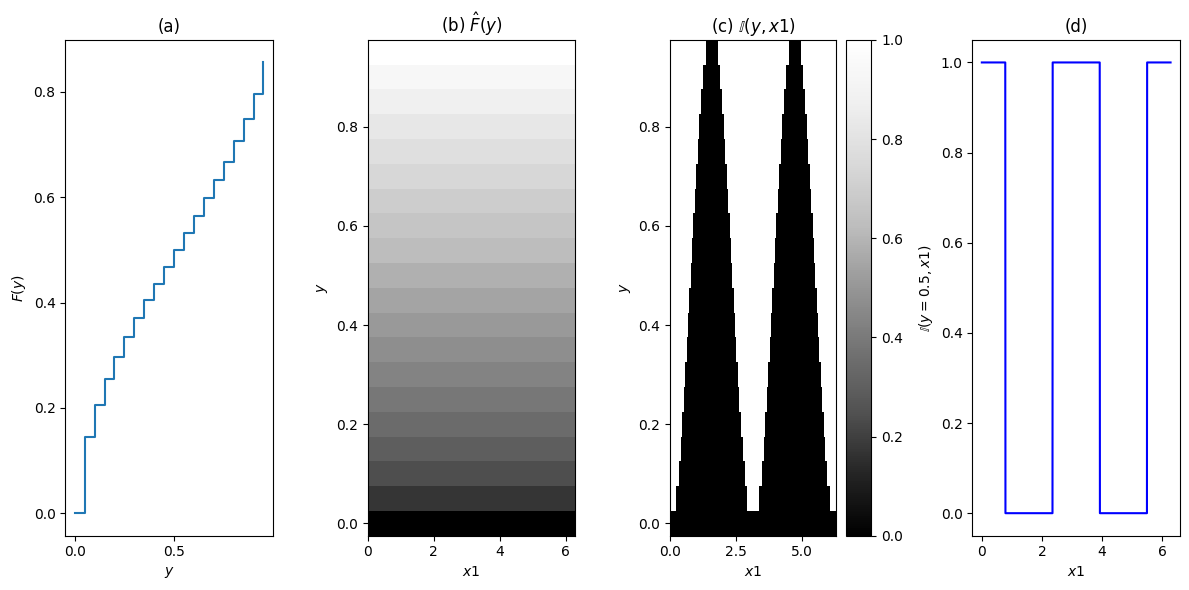

In [2]:
import numpy as np
import matplotlib.pyplot as plt

n  = 20 # Number of bins

fig = plt.figure(figsize=(12,6))

# Motivating the function space
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x1 = np.linspace(0,2*np.pi,10**3)
Y  = lambda x: np.sin(x)**2;

I  = lambda Y,y_m: [1 if Y_i < y_m else 0 for Y_i in Y];

dy = abs( max(Y(x1)) - min(Y(x1)) )/n;
y  = np.arange(min(Y(x1)),max(Y(x1)),dy);
F  = [ np.mean(I(Y(x1),y_m)) for y_m in y ];


ax1 = fig.add_subplot(141)
ax1.plot(y,F, drawstyle='steps-post')
ax1.set_title(r'(a)')
ax1.set_xlabel(r'$y$')
ax1.set_ylabel(r'$F(y)$')

ax2 = fig.add_subplot(142)
ax2.set_title(r'(b) $\hat{F}(y)$')
ax2.pcolormesh(x1,y,np.outer(np.ones(len(x1)),F).T,cmap='Greys_r')
ax2.set_xlabel(r'$x1$')
ax2.set_ylabel(r'$y$')

IYX = np.zeros((n,len(x1)))
for i,y_m in enumerate(y):
  IYX[i,:] = I(Y(x1),y_m)

ax3 = fig.add_subplot(143)
ax3.set_title(r'(c) $\mathbb{I}(y,x1)$')
im = ax3.pcolormesh(x1,y,IYX,cmap='Greys_r')
fig.colorbar(im, ax=ax3)
ax3.set_xlabel(r'$x1$')
ax3.set_ylabel(r'$y$')

ax4 = fig.add_subplot(144)
ax4.plot(x1,I(Y(x1),0.5),'b')
ax4.set_title(r'(d)')
ax4.set_xlabel(r'$x1$')
ax4.set_ylabel(r'$\mathbb{I}(y=0.5,x1)$')

plt.tight_layout()
plt.show()


In the example above we have (1) implicitly assumed a basis of piecewise constant functions and (2) regarded the random field not as a continuous function of space but instead as a vector of grid point evaluations. How do we refine this approach?

To address the first point we can define an appropriate function space
\begin{equation*}
    F \in V_F \subset L^2(\Omega_Y), \quad \text{where} \quad F: \Omega_Y \to [0,1] \quad \text{s.t.} \; \int F^2 dy < \infty,
\end{equation*}
followed by a set of basis functions $\{\phi_i(y)\} \in V_F$ such that
\begin{equation*}
    F(y) = \sum_i f_i \phi_i(y).
\end{equation*}
By choosing the space of square integrable functions we ensure that $F$ is monotonic. While this does not garauntee continuity we will see that this is not strictly necessary if we only require $f(y)$ to be continuous. Furthermore by formulating the problem in this manner we can modify the definition of $V_F$ as required.


To address the second point we now consider the projection of $F(y)$ into $V_F$ as defined by
\begin{equation*}
    \int_{\Omega_Y \times \Omega} \hat{F} \hat{v} \; dy d \boldsymbol{x} = \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\boldsymbol{x}) \hat{v} \; dy d \boldsymbol{x},
\end{equation*}
where $\hat{v},\hat{F} \in \hat{V}_F$ denotes the extension of $v,F \in V_F$ into $\Omega$. Substituting in for $\hat{F}$ and considering the projection component-wise we obtain
\begin{equation*}
    \sum_{i,j} \left[ \int_{\Omega_Y \times \Omega} \hat{\phi}_i \hat{\phi}_j \; dy d \boldsymbol{x} \right] f_j = \sum_i \left[ \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\boldsymbol{x}) \hat{\phi}_i(y,\boldsymbol{x}) \; dy d \boldsymbol{x} \right],
\end{equation*}
where the left hand side denotes the bilinear form and the right hand side the linear form.


Applying this equation to the example problem, we find that the precise statement of these function spaces for $\hat{F}$ and its basis functions $\hat{v}$ is
\begin{equation}
    \hat{V}_F = V_F \times R,
\end{equation}
the space of square integrable functions $V_F$ times $R$ the space of functions which are constant over the whole domain. These spaces correspond to the $y$ and $x_1$ axis of frame (b) in the example shown above, whose 1D projection is shown in frame (a). Conversely for the indicator function we have
\begin{equation}
    V_I = V_F \times W,
\end{equation}
the space of square integrable functions $V_F$ times $W$ the space of functions which are piecewise constant over the whole domain. These spaces correspond to $y$ and $x_1$ axis of frame (c) in the example shown above. In the right most frame (d) we show a cut of frame (c) to highlight the discontinuous dependence of the indicator function on $x_1$.

To realise these function spaces we will make use of the finite element code Firedrake.

In [83]:
from firedrake import *

# Construct the mesh
Ny   = 50
m_x  = IntervalMesh(1,0,2*np.pi); cell_type = "interval";  # x-direction
#m_x  = RectangleMesh(1,1,Lx=2*np.pi,Ly=4*np.pi, originX=0.0, originY=0.0); cell_type = "triangle";
mesh = ExtrudedMesh(m_x, layers=Ny,layer_height=1./Ny,extrusion_type='uniform') # y-direction
File("Exruded_Mesh.pvd").write(mesh)

# # Set the function-space \hat{V}_F
R   = FiniteElement(family="DG",cell=cell_type ,degree=0) # R   - here we use DG0 instead
V_F = FiniteElement(family="CG",cell="interval",degree=1) # V_F - piecewise linear elements

elt_RVF = TensorProductElement(R,V_F)
V_hat_F = FunctionSpace(mesh,elt_RVF)

# Set the function-space V_I
W   = FiniteElement(family="CG",cell=cell_type ,degree=30) # W   - here we use a high order element
V_F = FiniteElement(family="CG",cell="interval",degree=1 ) # V_F - piecewise linear elements

elt_WVF = TensorProductElement(W,V_F) # Could use OuterProductElement here too
V_I     = FunctionSpace(mesh,elt_WVF)

To inspect and visualise the mesh created we can use pyvista

In [70]:
# Get information on the mesh
reader = pv.get_reader(filename="Exruded_Mesh.pvd")
fdrake_mesh = reader.read()[0]
fdrake_mesh#.plot()

UnstructuredGrid (0x7d1e151ba500)
  N Cells:    50
  N Points:   102
  X Bounds:   0.000e+00, 6.283e+00
  Y Bounds:   0.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

In [ ]:
# Visualise the mesh
static_plotter = pv.Plotter()
static_plotter.add_mesh(fdrake_mesh, color='black', style='wireframe', line_width=2)
static_plotter.add_points(fdrake_mesh.points, color='red', point_size=8)
static_plotter.add_axes()
#static_plotter.camera_position = 'xy'
static_plotter.show()

# How to add scalars to this?

We then declare our CDF over our function space and assign it the value of our right hand side. This will be the indicator function acting on the random function $Y(\boldsymbol{x})$

In [84]:
# Define the indicator function
I   = Function(V_I)
x,y = SpatialCoordinate(mesh)

# How to print these out??

# Use a conditional expression
Indicator = conditional( sin(x)**2 < y, 1.0, 0.0)
I.interpolate( Indicator )
File("Indicator_Function.pvd").write(I)

reader = pv.get_reader(filename="Indicator_Function.pvd")
fdrake_mesh = reader.read()[0]
fdrake_mesh#.plot(cpos='xy',cmap='coolwarm')

UnstructuredGrid (0x7d1e46352c80)
  N Cells:    50
  N Points:   46531
  X Bounds:   0.000e+00, 6.283e+00
  Y Bounds:   0.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

We declare the bilinear and linear forms for the left and right hand sides of our equation and then we solve the equation, by defining $F$ to be a function holding the solution and then passing this along with $a$ and $L$ to a solver.

In [85]:
u = TrialFunction(V_hat_F)
v = TestFunction(V_hat_F)

a = inner(u,v) * dx
L = inner(I,v) * dx

F = Function(V_hat_F)
solve(a == L, F, solver_parameters={'ksp_type':'cg','pc_type':'none'})
File("CDF_Extended.pvd").write(F)

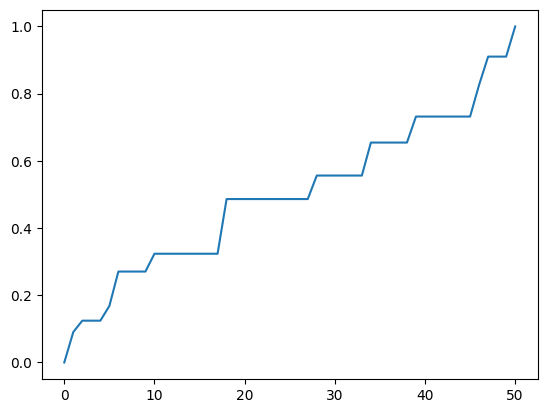

In [92]:
import matplotlib.pyplot as plt
#help(F.dat)
Fy = F.dat.data
plt.plot(Fy)
plt.show()

The 2D output can be visualised in paraview or the 1D function by running

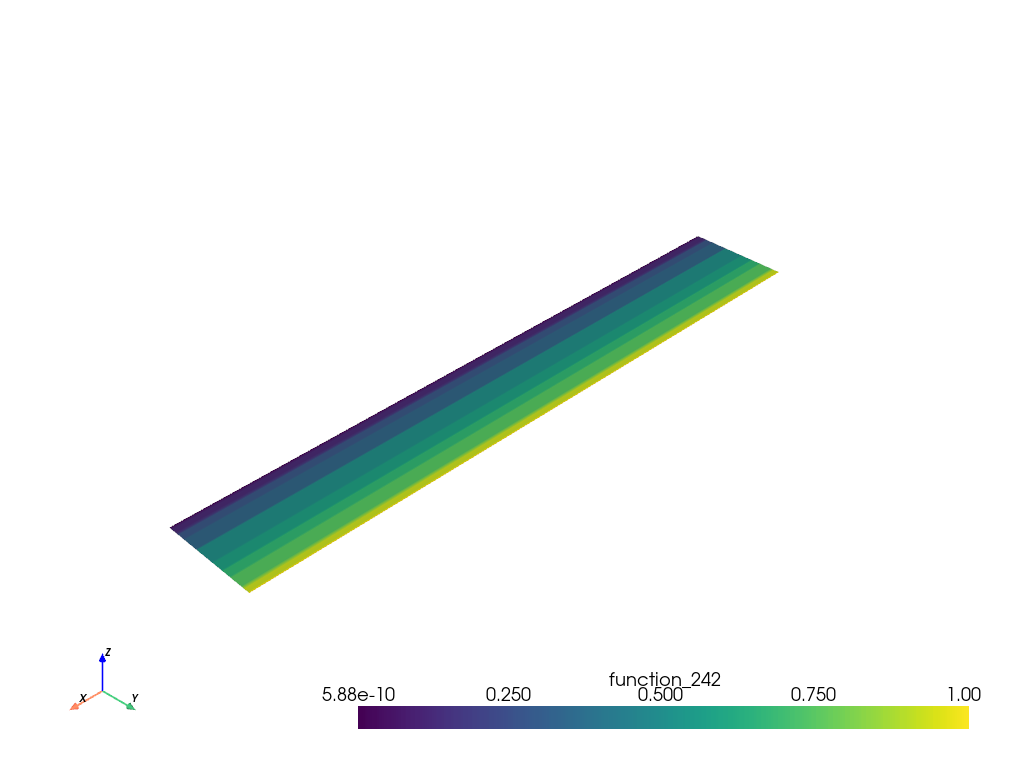

In [86]:
reader = pv.get_reader(filename="CDF_Extended.pvd")
fdrake_mesh = reader.read()[0]
fdrake_mesh.plot()

Having constructed the CDF $F(y)$ we now turn to constructing its PDF $f(y)$ which must remain positive and integrate to one. While strictly speaking the PDF is the derivative of the CDF, we choose to recover the PDF via a projection as this requires less regularlity. To do so define the function space of $f(y)$ to be
\begin{equation*}
    f \in V_f \subset H^1(\Omega_Y), \quad \text{where} \quad f:\Omega_Y \to \mathbb{R}^+ \quad \text{s.t.} \; \left\{ \int f^2 dy < \infty, \int |\nabla f|^2 dy < \infty \right\},
\end{equation*}
thus allowing for weak derivatives followed by a set of basis functions $\{\varphi_i(y)\} \in V_f$ such that
\begin{equation*}
    f(y) = \sum_i f_i \varphi_i(y).
\end{equation*}
We then define the projection in each element $e$ as
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = \int_{e} \varphi_e \partial_y F(y) \; dy, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
which can be integrated by parts in order to put the derivative onto $v$ thus resulting in a boundary flux
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = -\int_{e} F(y) \partial_y \varphi_e \; dy + \int_{\partial e} F \varphi_e \cdot \vec{n}_e \; dS, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
and $\vec{n}_e$ is the outward pointing unit normal. Since $F$ is discontinuous, as evidenced by the previous figure, we have to choose how it is defined at the element facets. To ensure a stable scheme we choose upwinding, which means that must must specify the choice of $F$ at the edges of the domain as well as the interior facets.

Summing the contribution of all the elements $\sum_e \int_e \cdot \; dy = \int_{\Omega_Y} \cdot \; dy$ we obtain
\begin{align}
    \int_{\Omega_Y} v f(y) \; dy = & - \int_{\Omega_Y}        F(y) \partial_y v \; dy \\
                                   & + \int_{\Gamma_{int}}    F_+ v \cdot \vec{n}_e \; dS \\
                                   & + \int_{\Gamma_{max(y)}} F_- v \cdot \vec{n} \; ds \quad \forall v \in V_{f},
\end{align}
where the terms on the left hand side correspond to the cell integral and the integral at right most boundary where we take the interior solution $F_-$. The left most boundary need not be included as for a CDF $F=0$ by definition while the integral over the set of all interior facets $\Gamma_{int}$ vanishes when we upwind.

In [ ]:
V_f = FunctionSpace(mesh,"CG",1) # Define a function space consisting of piecewise linear functions

u = TrialFunction(V_f)
v = TestFunction(V_f)

n = FacetNormal(mesh)

# Define the variational forms for the previous equation
a =  inner(u,v) * dx
L = -inner(F,v.dx(0)) * dx  +  F*v*ds(2)


f = Function(V_f)
solve(a == L, f, solver_parameters={'ksp_type':'cg','pc_type':'none'})
File("PDF_Rayleigh_Benard.pvd").write(f)

Finally we visualise the PDF below

<Figure size 640x480 with 0 Axes>

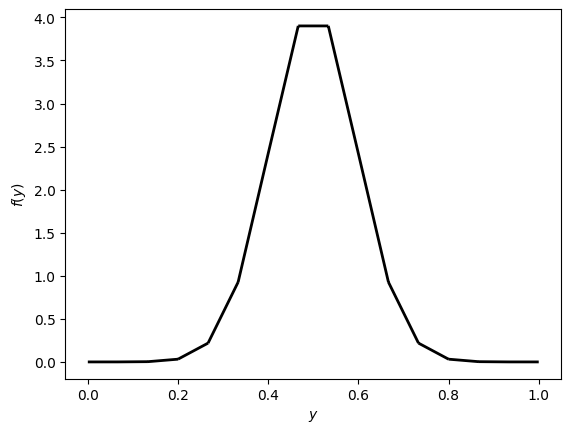

In [ ]:
try:
  import matplotlib.pyplot as plt
except:
  warning("Matplotlib not imported")

try:
  fig    = plt.figure()
  Line2D = plot(f)
  plt.xlabel(r'$y$')
  plt.ylabel(r'$f(y)$')

except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)

try:
  plt.show()
except Exception as e:
  warning("Cannot show figure. Error msg: '%s'" % e)


In [ ]:
# from firedrake import *

# m_Y  = IntervalMesh(15,0,1)       # Construct a mesh using 10 elements
# mesh = ExtrudedMesh(m_Y,10)

# V_Y = FiniteElement("CG",m_Y.cell,1)
# V_x1= FiniteElement("R",interval,0)

# elt = TensorProductElement(V_Y,V_x1)

# V_F  = FunctionSpace(mesh,elt) # Define a function space consisting of piecewise constant functions
# V_F_Y = FunctionSpace(m_Y, V_Y)

# F  = Function(V_F)
# F_Y = Function(V_F_Y, val=F.dat)

# u = TrialFunction(V_F)
# v = TestFunction(V_F)